## Driver code comparing different QC / OD lists 
- QC: manual / visual quality checks
- OD: automatic outlier detection 

### Steps
- import CSVs from QC / OD procedures
- compare overlap of subjects

In [1]:
import sys
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2, venn3

sys.path.append('../')
from lib.data_handling import *
from lib.data_stats import *

### Data paths

In [2]:
#proj_dir = '/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/'
proj_dir = '/home/nikhil/projects/CT_reproduce/'
data_dir = proj_dir + 'data/'
qc_dir =  data_dir + 'QC/'


# Gleb / Marten visual QC
manual_outlier_file = qc_dir + 'master_QC_table.csv'

# Automated outliers
pipeline_outlier_file = qc_dir + 'pipeline_outlier_data.csv'

aparc_outlier_file = qc_dir + 'aparc_outlier_data.csv'
destr_outlier_file = qc_dir + 'des_outlier_data.csv'
glass_outlier_file = qc_dir + 'glas_outlier_data.csv'

highdim_lh_ctrl = qc_dir + 'high-dim/out_outlier_con_lh.csv'
highdim_rh_ctrl = qc_dir + 'high-dim/out_outlier_con_rh.csv'
highdim_lh_asd = qc_dir + 'high-dim/out_outlier_asd_lh.csv'
highdim_rh_asd = qc_dir + 'high-dim/out_outlier_asd_rh.csv'

outlier_file_dict = {'manual':manual_outlier_file,
                    'auto_pipline': pipeline_outlier_file,
                    'auto_aparc': aparc_outlier_file,
                    'auto_destr': destr_outlier_file,
                    'auto_glass': glass_outlier_file,
                    'auto_highdim_lh_ctrl':highdim_lh_ctrl,
                    'auto_highdim_rh_ctrl':highdim_rh_ctrl,
                    'auto_highdim_lh_asd':highdim_lh_asd,
                    'auto_highdim_rh_asd':highdim_rh_asd,}

# qc_criterion = ('QC_maarten',[0]) # keep subs
# qc_criterion = ('QC_gleb',['1','-+1']) # keep subs
# qc_criterion = ('outlier_all_data',[0])

### Global Var

In [3]:
subject_ID_col = 'SubjID'

In [4]:
outlier_data_dict = {}
for key in outlier_file_dict.keys():
    df = pd.read_csv(outlier_file_dict[key], dtype={'SubjID': int})
    if key == 'manual':
        df.loc[df['QC_maarten'] != 0.0, 'QC_maarten'] = 1.0
        df.loc[df['QC_gleb'] == '1', 'QC_gleb'] = 0.0
        df.loc[df['QC_gleb'] == '-+1', 'QC_gleb'] = 0.0
        df.loc[df['QC_gleb'] != 0.0, 'QC_gleb'] = 1.0
    
    if key == 'auto_highdim_lh_ctrl':
        df = df.rename(columns={'sub_id_con_lh':subject_ID_col,'outlier_ind':'outlier_ind_lh'})
    if key == 'auto_highdim_rh_ctrl':
        df = df.rename(columns={'sub_id_con_rh':subject_ID_col,'outlier_ind':'outlier_ind_rh'})
    if key == 'auto_highdim_lh_asd':
        df = df.rename(columns={'sub_id_asd_lh':subject_ID_col,'outlier_ind':'outlier_ind_lh'})
    if key == 'auto_highdim_rh_asd':
        df = df.rename(columns={'sub_id_asd_rh':subject_ID_col,'outlier_ind':'outlier_ind_rh'})
        
    outlier_data_dict[key] = df
    print('shape of QC file {}: {}'.format(key,df.shape))
    
#Append contrls and asds and combine left and right
a = outlier_data_dict['auto_highdim_lh_ctrl'].append(outlier_data_dict['auto_highdim_lh_asd'])
b = outlier_data_dict['auto_highdim_rh_ctrl'].append(outlier_data_dict['auto_highdim_rh_asd'])
c = pd.merge(a,b, on=subject_ID_col)
c['OD_high_dim'] = (c['outlier_ind_lh']==1.0) | (c['outlier_ind_rh']==1.0)
c['OD_high_dim'] = c['OD_high_dim'].astype(int)
outlier_data_dict['auto_highdim'] = c

shape of QC file manual: (1031, 6)
shape of QC file auto_pipline: (3890, 4)
shape of QC file auto_aparc: (1047, 4)
shape of QC file auto_destr: (1047, 4)
shape of QC file auto_glass: (1047, 4)
shape of QC file auto_highdim_lh_ctrl: (542, 3)
shape of QC file auto_highdim_rh_ctrl: (542, 3)
shape of QC file auto_highdim_lh_asd: (508, 3)
shape of QC file auto_highdim_rh_asd: (508, 3)


In [15]:
high_dim_outlier_data.shape

(1050, 4)

### Save high-dim outlier list formatted

In [11]:
save_data = False
save_path = qc_dir + 'high-dim/high_dim_outlier_data.csv'

high_dim_outlier_data = c[['SubjID','outlier_ind_lh','outlier_ind_rh','OD_high_dim']].copy()
if save_data:
    high_dim_outlier_data.to_csv(save_path)
    
high_dim_outlier_data

,SubjID,outlier_ind_lh,outlier_ind_rh,OD_high_dim
0,50822,0,0,0
1,50785,0,0,0
2,50788,0,0,0
3,50777,0,0,0
4,50818,0,0,0
5,50773,0,0,0
6,50812,0,0,0
7,50779,0,0,0
8,50820,0,0,0
9,50817,0,0,0


In [6]:
master_QC_OD_df = pd.DataFrame(columns=[subject_ID_col])
master_QC_OD_df[subject_ID_col] = outlier_data_dict['auto_aparc'][subject_ID_col]

# Manual
manual_df = outlier_data_dict['manual'][[subject_ID_col,'QC_maarten','QC_gleb']]
master_QC_OD_df = pd.merge(master_QC_OD_df, manual_df, on=subject_ID_col, how='left')

# Pipelines
pipe_df = outlier_data_dict['auto_pipline']
for pipe in pipe_df['pipeline'].unique():
    df = pipe_df[pipe_df['pipeline']==pipe][[subject_ID_col,'outlier_ind']]
    df = df.rename(columns={'outlier_ind':'OD_{}_DKT'.format(pipe)})
    master_QC_OD_df = pd.merge(master_QC_OD_df, df, on=subject_ID_col, how='left')

# Atlases
for atlas in ['aparc','destr','glass']:
    atlas_df = outlier_data_dict['auto_{}'.format(atlas)][[subject_ID_col,'outlier_all_data']]
    atlas_df = atlas_df.rename(columns={'outlier_all_data':'OD_FS6.0_{}'.format(atlas)})
    master_QC_OD_df = pd.merge(master_QC_OD_df, atlas_df, on=subject_ID_col, how='left')

# Legacy code
# # High-dim (outlier_ind)
# for highdim in ['lh_ctrl','rh_ctrl','lh_asd','rh_asd']:
#     highdim_df = outlier_data_dict['auto_highdim_{}'.format(highdim)][[subject_ID_col,'outlier_ind']]
#     highdim_df = highdim_df.rename(columns={'outlier_ind':'OD_FS6.0_{}_outlier_ind'.format(highdim)})
#     master_QC_OD_df = pd.merge(master_QC_OD_df, highdim_df, on=subject_ID_col, how='left')

highdim_df = outlier_data_dict['auto_highdim']
master_QC_OD_df = pd.merge(master_QC_OD_df, highdim_df[[subject_ID_col,'OD_high_dim']], on=subject_ID_col, how='left')

In [6]:
master_QC_OD_df.columns

Index(['SubjID', 'QC_maarten', 'QC_gleb', 'OD_ants_DKT', 'OD_civet_DKT',
       'OD_fs51_DKT', 'OD_fs53_DKT', 'OD_fs60_DKT', 'OD_FS6.0_aparc',
       'OD_FS6.0_destr', 'OD_FS6.0_glass', 'OD_high_dim'],
      dtype='object')

In [46]:
outlier_cols = [ 'QC_maarten', 'QC_gleb', 'OD_ants_DKT', 'OD_civet_DKT',
       'OD_fs51_DKT', 'OD_fs53_DKT', 'OD_fs60_DKT', 'OD_FS6.0_aparc',
       'OD_FS6.0_destr', 'OD_FS6.0_glass', 'OD_high_dim']

master_QC_OD_df = master_QC_OD_df.fillna(1)
master_QC_OD_df['QC_sum'] = master_QC_OD_df[outlier_cols].sum(axis=1)

### QC stats based on subjects used in the analysis

In [16]:
proj_dir = '/home/nikhil/projects/CT_reproduce/'
data_dir = proj_dir + 'code/compare-surf-tools/data/'
results_dir = proj_dir + 'data/results/'
qc_dir =  data_dir + 'QC/'
qc_list = ['manual_lenient','manual_stringent','auto_low_dim','auto_high_dim']

In [17]:
# QC/outlier files
manual_outlier_file = qc_dir + 'manual/master_QC_table.csv'
auto_low_dim_outlier_file = qc_dir + 'auto/software/software_outlier_data.csv'
auto_high_dim_outlier_file = qc_dir + 'auto/high-dim/high_dim_outlier_data.csv'

In [73]:
qc_df_concat = pd.DataFrame()
for q, qc in enumerate(qc_list):           
    if qc == 'manual_lenient':
        qc_df = pd.read_csv(manual_outlier_file, dtype={'SubjID': int})
        qc_criterion = ('QC_maarten',[0]) # keep subs
    elif qc == 'manual_stringent':
        qc_df = pd.read_csv(manual_outlier_file, dtype={'SubjID': int})
        qc_criterion = ('QC_gleb',['1','-+1']) # keep subs
        qc_df['QC_gleb_binary'] = qc_df['QC_gleb'].isin(['1','-+1'])
    elif qc == 'auto_low_dim':
        qc_df_long = pd.read_csv(auto_low_dim_outlier_file ,dtype={'SubjID': int})
        qc_df = qc_df_long.pivot(index=subject_ID_col,columns='pipeline',values='outlier_ind')
        qc_df.apply(pd.to_numeric)
        #keep only if a subject is not an outlier in any of the software
        qc_df['auto_low_dim'] = qc_df[list(qc_df.columns)].sum(axis=1) 
        qc_df[subject_ID_col] = qc_df.index
        qc_criterion = ('auto_low_dim',[0])                
    elif qc == 'auto_high_dim':
        qc_df = pd.read_csv(auto_high_dim_outlier_file, dtype={'SubjID': int})
        qc_criterion = ('OD_high_dim',['0']) # keep subs
    else:
        print('Unknow QC type')
    
    # Binary: 1-outlier 0-not-outlier
    qc_df['{}_binary'.format(qc_criterion[0])] = ~qc_df[qc_criterion[0]].isin(qc_criterion[1])
    if qc_df.index.name == 'SubjID':
        qc_df_filter = qc_df['{}_binary'.format(qc_criterion[0])].reset_index()
    else:
        qc_df_filter = qc_df[['SubjID','{}_binary'.format(qc_criterion[0])]]
    if q == 0:
        qc_df_conat = qc_df_filter
    else:
        qc_df_conat = pd.merge(qc_df_conat, qc_df_filter, on='SubjID',how='outer')
        
# Fill unknown subjects as outliers
qc_df_conat = qc_df_conat.fillna(False).astype(int)

In [86]:
outlier_cols = ['QC_maarten_binary','QC_gleb_binary','auto_low_dim_binary','OD_high_dim_binary']
qc_df_conat['QC_sum'] = qc_df_conat[outlier_cols].sum(axis=1)
qc_df_conat['QC_sum'].value_counts()

1    665
0    288
3     68
2     60
4      4
Name: QC_sum, dtype: int64

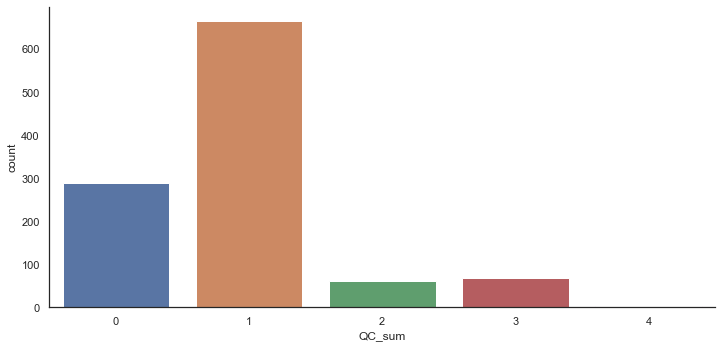

In [85]:
plot_df = qc_df_conat
sns.set(font_scale=1)
with sns.axes_style("white"):
    g = sns.catplot(x='QC_sum',kind='count',aspect=2,data=plot_df)
    #g = sns.distplot(plot_df['QC_sum'])

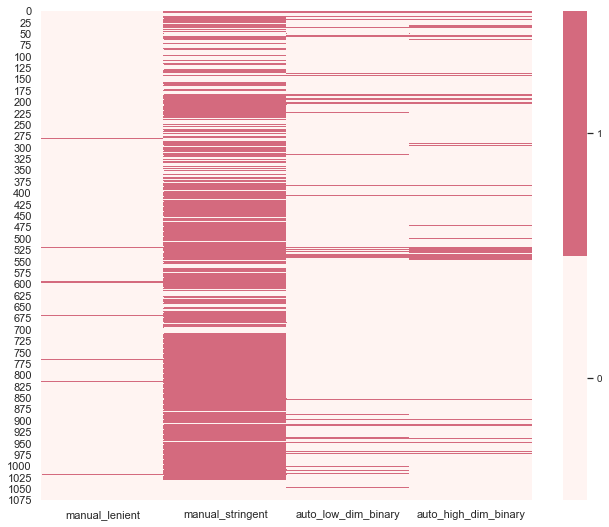

In [91]:
plot_df = qc_df_conat[outlier_cols]
plot_df = plot_df.rename(columns={'QC_maarten_binary':'manual_lenient','QC_gleb_binary':'manual_stringent',
                                  'OD_high_dim_binary':'auto_high_dim_binary'})
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.xkcd_palette(["very light pink",'pinkish']) #sns.diverging_palette(220, 10, as_cmap=True)

with sns.axes_style("white"):
    sns.set(font_scale=1)
    g = sns.heatmap(plot_df, cmap=cmap)
    colorbar = g.collections[0].colorbar
    colorbar.set_ticks([0.25,0.75])
    colorbar.set_ticklabels(['0', '1'])
    g.figure.axes[-1].tick_params(labelsize=10)